###Imports

In [1]:
import pandas as pd
from math import sqrt
import numpy as np
from math import exp
from math import pi
from collections import Counter
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB

### Read Data

In [2]:
train_df = pd.read_csv('../data/Annotation/joined/joined_train.csv', index_col='id')
test_df = pd.read_csv('..//data/Annotation/joined/joined_test.csv', index_col='id')
print(train_df.shape)
print(test_df.shape)

(12271, 772)
(3068, 772)


### Setting up baseline using sklearn's GaussianNB

In [3]:
clf = GaussianNB()
label = train_df['label']
features = train_df.drop(columns=['label'])
clf.fit(features, label)

GaussianNB()

In [4]:
test_label = test_df['label']
test_feat = test_df.drop(columns=['label'])
pred = clf.predict(test_feat)

In [5]:
acc_sklearn = accuracy_score(test_label, pred)
acc_sklearn

0.3644067796610169

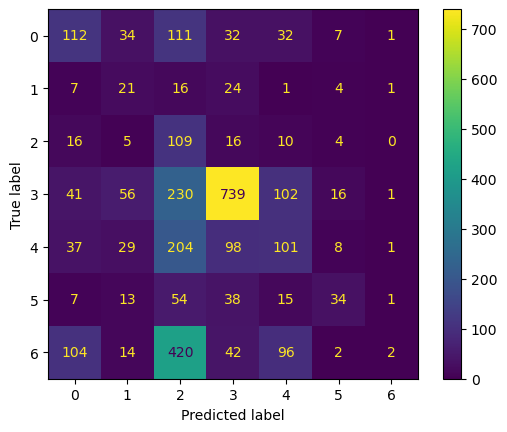

In [6]:
ConfusionMatrixDisplay.from_predictions(test_label, pred)

### Naive Bayes Algorithm

In [7]:
def naive_bayes(train, test):
    train_summary = summarize_by_class(train)
    predictions = list()
    for idx, row in test.iterrows():
        output = predict(train_summary, row)
        predictions.append(output)
    return(predictions)

In [8]:
'''
1. split the data by class label
2. calcualte statistical summaries (mean & standard deviation) for each row 
'''
def summarize_by_class(data):
    split = split_by_class(data)
    summaries = dict()
    for cls, rows in split.items():
        summaries[cls] = summarize_data(rows)
    return summaries

In [9]:
# Split the data by class label
def split_by_class(data):
    split = dict()
    for i in range(len(data)):
        row = data.iloc[i]
        cls = row['label']
        if (cls not in split):
            split[cls] = list()
        split[cls].append(row.drop('label'))
    return split

In [10]:
# Calculate the mean, standard deviation and count for each column
def summarize_data(data):
    return [(calculate_mean(column), calculate_stdev(column), len(column)) for column in zip(*data)]

In [11]:
def calculate_mean(numbers):
  return sum(numbers)/float(len(numbers)) if len(numbers) != 0 else 0

In [12]:
def calculate_stdev(numbers):
    avg = calculate_mean(numbers)
    var = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
    return sqrt(var)

In [13]:
# Predict the label for the given row
def predict(summaries, row):
    probabilities = calculate_class_probabilities(summaries, row)
    best_label, best_prob = None, -1
    for class_value, probability in probabilities.items():
        if best_label is None or probability > best_prob:
            best_prob = probability
            best_label = class_value
    return best_label

In [14]:
# Calculate the probabilities of predicting each class for the given row
def calculate_class_probabilities(summaries, row):
    total_rows = sum([summaries[key][0][2] for key in summaries])
    prob = dict()
    for cls, summary in summaries.items():
      #priors
      prob[cls] = summaries[cls][0][2] /float(total_rows)
      
      for i in range(len(summary)):
          mean, stdev, _ = summary[i]
          prob[cls] *= calculate_probability(row[i], mean, stdev)
            
    return prob

In [15]:
# Calculate the Gaussian probability distribution
def calculate_probability(x, mean, stdev):
  #smoothing in case all values are the same - may happen in case of DLPCNN and
  #other auto feature-extraction outputs, where the resultant features are sparse
  if stdev == 0:
    stdev = 0.01
  exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
  return (1 / (sqrt(2 * pi) * stdev)) * exponent

In [16]:
pred = naive_bayes(train_df, test_df)

In [17]:
acc = accuracy_score(test_df['label'].tolist(), pred)
acc

0.3898305084745763

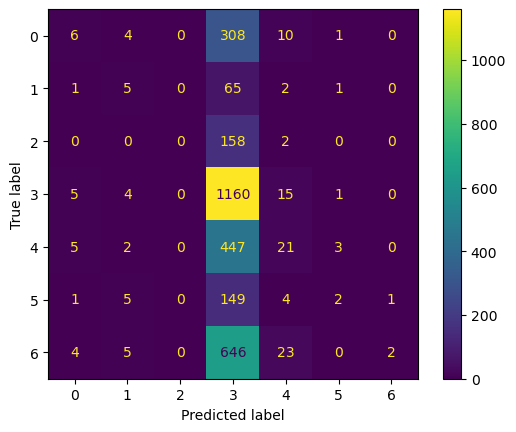

In [18]:
ConfusionMatrixDisplay.from_predictions(test_df['label'].tolist(), pred)

In [19]:
Counter(train_df['label'])

Counter({3: 4772, 4: 1982, 6: 2524, 0: 1290, 2: 717, 5: 705, 1: 281})

In [20]:
Counter(test_df['label'])

Counter({3: 1185, 0: 329, 4: 478, 2: 160, 6: 680, 5: 162, 1: 74})

In [24]:
import os
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred):
    cls_report = classification_report(y_true, y_pred)
    print('\nClassification Report')
    print('======================================================')
    print('\n', cls_report)
    with open(os.path.join('../metrics', 'nb.txt'), 'w') as f:
        f.write(cls_report)

In [25]:
print_classification_report(test_df['label'].tolist(), pred)


Classification Report

               precision    recall  f1-score   support

           0       0.27      0.02      0.03       329
           1       0.20      0.07      0.10        74
           2       0.00      0.00      0.00       160
           3       0.40      0.98      0.56      1185
           4       0.27      0.04      0.08       478
           5       0.25      0.01      0.02       162
           6       0.67      0.00      0.01       680

    accuracy                           0.39      3068
   macro avg       0.29      0.16      0.11      3068
weighted avg       0.39      0.39      0.24      3068



/Users/kushal/opt/anaconda3/envs/jupyter_lab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushal/opt/anaconda3/envs/jupyter_lab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushal/opt/anaconda3/envs/jupyter_lab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

### Remarks
Looks like our model is predicting every sample as an
instance of label 4 for some reason. Looking at the count of different labels, it looks like our data is skewed towards label 4, hence the prior probability of label 4 is much higher in comparison with the other classes.

How to fix this? 

1.   Try undersampling/oversampling techniques
2.   Use some kind of smoothing to balance out the disproportionate class distributions
3. Explore more options


